In [2]:
import math
import os
import random
import time
import json
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from collections import defaultdict


# Try to import BLEU score calculation
try:
    from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
    nltk.download('punkt', quiet=True)
    BLEU_AVAILABLE = True
except ImportError:
    BLEU_AVAILABLE = False
    print("NLTK not available for BLEU scores")

In [3]:
@dataclass
class Config:
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    # Data configuration
    use_builtin_tiny_corpus: bool = False  # Use WikiText-2 for more realistic dataset
    context_len: int = 128  # Increased for better context
    train_frac: float = 0.85

    # Model architecture
    vocab_size: int = 0  # Will be set after tokenizer creation
    d_model: int = 256  # Increased model size
    n_heads: int = 8
    n_layers: int = 4    # Increased depth
    dropout: float = 0.1

    # Training parameters
    batch_size: int = 32
    lr: float = 1e-4     # Lower learning rate for stability
    weight_decay: float = 0.01

    # Training steps
    max_steps_pretrain: int = 2000
    max_steps_sft: int = 800
    max_steps_rl: int = 400
    eval_every: int = 100
    save_every: int = 500

    # Generation parameters
    temperature: float = 0.8
    top_k: Optional[int] = 40
    max_gen_length: int = 100


In [4]:
CFG = Config()

# Set seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CFG.seed)

# Enhanced data loading with better corpus
def load_enhanced_corpus():
    """Load a more substantial corpus for training"""
    if CFG.use_builtin_tiny_corpus:
        return """From fairest creatures we desire increase,
That thereby beauty's rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:
But thou contracted to thine own bright eyes,
Feed'st thy light'st flame with self-substantial fuel,
Making a famine where abundance lies,
Thy self thy foe, to thy sweet self too cruel."""

    try:
        from datasets import load_dataset
        print("Loading WikiText-2 dataset...")
        ds = load_dataset("wikitext", "wikitext-2-raw-v1")

        # Take more substantial portion for better training
        train_texts = [text for text in ds['train']['text'][:1000] if text.strip()]
        corpus = "\n".join(train_texts)

        # Clean the text
        corpus = corpus.replace(" = ", " ")
        corpus = " ".join(corpus.split())  # Normalize whitespace

        print(f"Loaded corpus with {len(corpus)} characters")
        return corpus

    except Exception as e:
        print(f"Failed to load WikiText-2: {e}")
        print("Using built-in corpus...")
        return load_enhanced_corpus()

In [5]:
# Enhanced tokenizer with better vocabulary handling
class EnhancedCharTokenizer:
    def __init__(self, text: str, min_freq: int = 2):
        # Build character vocabulary with frequency filtering
        char_counts = defaultdict(int)
        for char in text:
            char_counts[char] += 1

        # Keep characters that appear at least min_freq times
        vocab_chars = [char for char, count in char_counts.items() if count >= min_freq]
        vocab_chars = sorted(set(vocab_chars))

        # Add special tokens
        special_tokens = ['<PAD>', '<UNK>', '<START>', '<END>']
        vocab = special_tokens + vocab_chars

        self.stoi = {ch: i for i, ch in enumerate(vocab)}
        self.itos = {i: ch for i, ch in enumerate(vocab)}
        self.vocab_size = len(vocab)

        # Special token indices
        self.pad_idx = self.stoi['<PAD>']
        self.unk_idx = self.stoi['<UNK>']
        self.start_idx = self.stoi['<START>']
        self.end_idx = self.stoi['<END>']

        print(f"Built vocabulary with {self.vocab_size} tokens")

    def encode(self, text: str, add_special: bool = False) -> List[int]:
        tokens = []
        if add_special:
            tokens.append(self.start_idx)

        for char in text:
            tokens.append(self.stoi.get(char, self.unk_idx))

        if add_special:
            tokens.append(self.end_idx)

        return tokens

    def decode(self, token_ids: List[int], remove_special: bool = True) -> str:
        chars = []
        for token_id in token_ids:
            if token_id in self.itos:
                char = self.itos[token_id]
                if remove_special and char in ['<PAD>', '<UNK>', '<START>', '<END>']:
                    continue
                chars.append(char)
        return ''.join(chars)

In [6]:
# Enhanced dataset with better preprocessing
class EnhancedLMDataset(Dataset):
    def __init__(self, text: str, tokenizer: EnhancedCharTokenizer,
                 context_len: int = 128, split: str = "train",
                 train_frac: float = 0.85, stride: int = 64):

        self.tokenizer = tokenizer
        self.context_len = context_len

        # Encode the full text
        encoded_text = tokenizer.encode(text)

        # Split into train/validation
        split_idx = int(len(encoded_text) * train_frac)
        if split == "train":
            self.data = encoded_text[:split_idx]
        else:
            self.data = encoded_text[split_idx:]

        # Create overlapping windows for better coverage
        self.examples = []
        for i in range(0, len(self.data) - context_len - 1, stride):
            if i + context_len + 1 <= len(self.data):
                input_seq = self.data[i:i+context_len]
                target_seq = self.data[i+1:i+context_len+1]
                self.examples.append((input_seq, target_seq))

        print(f"Created {len(self.examples)} {split} examples")

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        input_seq, target_seq = self.examples[idx]
        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long)


In [7]:
# Enhanced model architecture
class EnhancedTinyGPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, dropout, context_len):
        super().__init__()

        self.d_model = d_model
        self.context_len = context_len

        # Embeddings
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Parameter(torch.zeros(1, context_len, d_model))
        self.dropout = nn.Dropout(dropout)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, dropout, context_len)
            for _ in range(n_layers)
        ])

        # Output layers
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)

        # Initialize weights
        self.apply(self._init_weights)

        # Count parameters
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Model initialized with {total_params:,} parameters")

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        assert T <= self.context_len, f"Sequence length {T} exceeds context length {self.context_len}"

        # Token and position embeddings
        tok_emb = self.tok_emb(idx)  # (B, T, d_model)
        pos_emb = self.pos_emb[:, :T, :]  # (1, T, d_model)
        x = self.dropout(tok_emb + pos_emb)

        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)

        # Final layer norm and projection
        x = self.ln_f(x)
        logits = self.head(x)  # (B, T, vocab_size)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens=50, temperature=1.0, top_k=None):
        self.eval()

        for _ in range(max_new_tokens):
            # Crop context if too long
            idx_cond = idx[:, -self.context_len:]

            # Forward pass
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / max(temperature, 1e-8)

            # Apply top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('inf')

            # Sample from distribution
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, dropout, context_len):
        super().__init__()

        self.ln1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads, dropout, context_len)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = MLP(d_model, dropout)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x


In [10]:
class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout, context_len):
        super().__init__()
        assert d_model % n_heads == 0

        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        # Query, key, value projections
        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.proj = nn.Linear(d_model, d_model)

        # Regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

        # Causal mask
        self.register_buffer("mask", torch.tril(torch.ones(context_len, context_len))
                            .view(1, 1, context_len, context_len))

    def forward(self, x):
        B, T, C = x.shape

        # Calculate query, key, values
        qkv = self.qkv(x)
        q, k, v = qkv.split(C, dim=2)

        # Reshape for multi-head attention
        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        # Attention computation
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_dim))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)

        y = att @ v  # (B, n_heads, T, head_dim)
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # Output projection
        y = self.proj_dropout(self.proj(y))
        return y


In [11]:
class MLP(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()

        self.fc1 = nn.Linear(d_model, 4 * d_model)
        self.fc2 = nn.Linear(4 * d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [12]:
# Enhanced evaluation utilities
class TrainingMetrics:
    def __init__(self):
        self.reset()

    def reset(self):
        self.train_losses = []
        self.val_losses = []
        self.train_perplexities = []
        self.val_perplexities = []
        self.learning_rates = []
        self.steps = []

    def update(self, step, train_loss, val_loss, lr):
        self.steps.append(step)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_perplexities.append(math.exp(min(train_loss, 10)))  # Clip for numerical stability
        self.val_perplexities.append(math.exp(min(val_loss, 10)))
        self.learning_rates.append(lr)

def evaluate_model(model, dataloader, tokenizer):
    """Comprehensive model evaluation"""
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(dataloader):
            if batch_idx >= 50:  # Limit evaluation for speed
                break

            x, y = x.to(CFG.device), y.to(CFG.device)
            logits, loss = model(x, y)

            total_loss += loss.item() * y.numel()
            total_tokens += y.numel()

    avg_loss = total_loss / total_tokens if total_tokens > 0 else float('inf')
    perplexity = math.exp(min(avg_loss, 10))  # Clip for numerical stability

    return avg_loss, perplexity


In [13]:
def calculate_bleu_scores(model, tokenizer, test_prompts, reference_texts):
    """Calculate BLEU scores for generated text"""
    if not BLEU_AVAILABLE:
        return None

    model.eval()
    bleu_scores = []

    for prompt, reference in zip(test_prompts, reference_texts):
        # Generate text
        input_ids = torch.tensor([tokenizer.encode(prompt)], device=CFG.device)
        generated_ids = model.generate(input_ids, max_new_tokens=50,
                                     temperature=CFG.temperature, top_k=CFG.top_k)

        # Extract only the generated part
        generated_text = tokenizer.decode(generated_ids[0][len(input_ids[0]):].tolist())

        # Calculate BLEU score
        reference_tokens = reference.split()
        generated_tokens = generated_text.split()

        if len(generated_tokens) > 0:
            bleu = sentence_bleu([reference_tokens], generated_tokens)
            bleu_scores.append(bleu)

    return np.mean(bleu_scores) if bleu_scores else 0.0

def plot_training_curves(metrics_dict, title="Training Curves Comparison"):
    """Plot comprehensive training curves"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)

    colors = ['blue', 'red', 'green', 'orange']

    # Loss curves
    for i, (name, metrics) in enumerate(metrics_dict.items()):
        color = colors[i % len(colors)]
        axes[0,0].plot(metrics.steps, metrics.train_losses,
                      color=color, alpha=0.7, label=f'{name} Train')
        axes[0,0].plot(metrics.steps, metrics.val_losses,
                      color=color, linestyle='--', alpha=0.7, label=f'{name} Val')

    axes[0,0].set_xlabel('Steps')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].set_title('Training Loss')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Perplexity curves
    for i, (name, metrics) in enumerate(metrics_dict.items()):
        color = colors[i % len(colors)]
        axes[0,1].plot(metrics.steps, metrics.val_perplexities,
                      color=color, alpha=0.7, label=f'{name}')

    axes[0,1].set_xlabel('Steps')
    axes[0,1].set_ylabel('Perplexity')
    axes[0,1].set_title('Validation Perplexity')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_yscale('log')

    # Learning rate curves
    for i, (name, metrics) in enumerate(metrics_dict.items()):
        if metrics.learning_rates:
            color = colors[i % len(colors)]
            axes[1,0].plot(metrics.steps, metrics.learning_rates,
                          color=color, alpha=0.7, label=f'{name}')

    axes[1,0].set_xlabel('Steps')
    axes[1,0].set_ylabel('Learning Rate')
    axes[1,0].set_title('Learning Rate Schedule')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Loss distribution
    all_train_losses = []
    all_val_losses = []
    labels = []

    for name, metrics in metrics_dict.items():
        all_train_losses.extend(metrics.train_losses[-10:])  # Last 10 values
        all_val_losses.extend(metrics.val_losses[-10:])
        labels.extend([f'{name}'] * len(metrics.train_losses[-10:]))

    if all_train_losses:
        axes[1,1].hist([metrics.train_losses[-20:] for metrics in metrics_dict.values()],
                      bins=20, alpha=0.7, label=list(metrics_dict.keys()))
        axes[1,1].set_xlabel('Loss Value')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].set_title('Loss Distribution (Final Epochs)')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [14]:
def generate_comparison_samples(models_dict, tokenizer, test_prompts):
    """Generate and compare samples from different models"""
    print("\n" + "="*80)
    print("SAMPLE GENERATION COMPARISON")
    print("="*80)

    for prompt in test_prompts:
        print(f"\nPrompt: '{prompt}'")
        print("-" * 60)

        for model_name, model in models_dict.items():
            model.eval()

            # Encode prompt
            input_ids = torch.tensor([tokenizer.encode(prompt)], device=CFG.device)

            # Generate text
            with torch.no_grad():
                generated_ids = model.generate(
                    input_ids,
                    max_new_tokens=CFG.max_gen_length,
                    temperature=CFG.temperature,
                    top_k=CFG.top_k
                )

            # Decode generated text
            full_text = tokenizer.decode(generated_ids[0].tolist())
            generated_only = tokenizer.decode(generated_ids[0][len(input_ids[0]):].tolist())

            print(f"\n{model_name}:")
            print(f"Full: {full_text[:200]}...")
            print(f"Generated: {generated_only[:150]}...")


In [15]:
# Enhanced SFT dataset creation
def create_enhanced_sft_dataset():
    """Create a more comprehensive SFT dataset"""
    sft_pairs = [
        # Educational content
        ("What is machine learning?", " Machine learning is a subset of AI that enables computers to learn from data without explicit programming."),
        ("Explain neural networks briefly.", " Neural networks are computing systems inspired by biological brains that learn patterns through interconnected nodes."),
        ("Define natural language processing.", " NLP is AI technology that helps computers understand, interpret, and generate human language."),

        # Creative tasks
        ("Write a haiku about technology:", " Silicon pathways, \nData flowing like rivers, \nFuture takes its shape."),
        ("Create a tagline for coffee:", " Brew your dreams, sip success."),
        ("Suggest a book title about AI:", " The Algorithm's Awakening: When Machines Learn to Dream"),

        # Practical questions
        ("How to improve writing skills?", " Read widely, practice daily, seek feedback, and study grammar and style guides consistently."),
        ("What makes a good leader?", " Good leaders show empathy, communicate clearly, make fair decisions, and inspire others to achieve common goals."),
        ("Tips for time management:", " Prioritize tasks, set realistic deadlines, eliminate distractions, and use tools like calendars and to-do lists."),

        # Technical explanations
        ("What is cloud computing?", " Cloud computing delivers computing services over the internet, including storage, processing, and software applications."),
        ("Explain blockchain simply.", " Blockchain is a digital ledger that records transactions across multiple computers in a secure, transparent way."),
        ("What are programming languages?", " Programming languages are formal languages with specific syntax and semantics used to write computer programs."),
    ]

    return sft_pairs

def build_sft_training_text(pairs):
    """Build formatted training text for SFT"""
    formatted_examples = []

    for question, answer in pairs:
        # Use a consistent format that's easy for the model to learn
        formatted_example = f"Question: {question}\nAnswer:{answer}\n\n"
        formatted_examples.append(formatted_example)

    return "".join(formatted_examples)


In [16]:
# Main training function
def train_model_phase(model, train_loader, val_loader, tokenizer,
                     phase_name, max_steps, metrics):
    """Enhanced training function with better monitoring"""

    print(f"\n{'='*60}")
    print(f"Starting {phase_name} Training")
    print(f"{'='*60}")

    # Setup optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_steps)

    model.train()
    step = 0
    running_loss = 0.0

    # Progress bar
    pbar = tqdm(total=max_steps, desc=f"{phase_name}")

    while step < max_steps:
        for batch_idx, (x, y) in enumerate(train_loader):
            if step >= max_steps:
                break

            x, y = x.to(CFG.device), y.to(CFG.device)

            # Forward pass
            logits, loss = model(x, y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            step += 1

            # Evaluation and logging
            if step % CFG.eval_every == 0 or step == 1:
                # Calculate average training loss
                avg_train_loss = running_loss / CFG.eval_every if step > 1 else loss.item()
                running_loss = 0.0

                # Evaluate on validation set
                val_loss, val_perplexity = evaluate_model(model, val_loader, tokenizer)

                # Update metrics
                current_lr = scheduler.get_last_lr()[0]
                metrics.update(step, avg_train_loss, val_loss, current_lr)

                # Update progress bar
                pbar.set_postfix({
                    'train_loss': f'{avg_train_loss:.4f}',
                    'val_loss': f'{val_loss:.4f}',
                    'val_ppl': f'{val_perplexity:.2f}',
                    'lr': f'{current_lr:.6f}'
                })

                model.train()  # Ensure model is in training mode

            pbar.update(1)

    pbar.close()

    # Final evaluation
    final_val_loss, final_val_ppl = evaluate_model(model, val_loader, tokenizer)
    print(f"\n{phase_name} completed!")
    print(f"Final validation loss: {final_val_loss:.4f}")
    print(f"Final validation perplexity: {final_val_ppl:.2f}")

    return model

In [17]:
# Bonus RL implementation (simplified REINFORCE)
class RLTrainer:
    def __init__(self, model, tokenizer, reward_fn):
        self.model = model
        self.tokenizer = tokenizer
        self.reward_fn = reward_fn
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr * 0.1)  # Lower LR for RL

    def simple_reward_function(self, prompt, generated_text):
        """Simple reward function based on length and keyword presence"""
        rewards = []

        # Length reward (prefer moderate lengths)
        length_score = max(0, 1 - abs(len(generated_text.split()) - 20) / 20)
        rewards.append(length_score * 0.3)

        # Keyword reward (prefer certain words)
        positive_keywords = ['good', 'great', 'excellent', 'amazing', 'wonderful']
        negative_keywords = ['bad', 'terrible', 'awful', 'horrible']

        keyword_score = 0
        words = generated_text.lower().split()
        for word in words:
            if word in positive_keywords:
                keyword_score += 0.2
            elif word in negative_keywords:
                keyword_score -= 0.2

        rewards.append(keyword_score)

        # Coherence reward (simple heuristic based on repetition)
        word_set = set(words)
        repetition_penalty = max(0, 1 - (len(words) - len(word_set)) / max(len(words), 1))
        rewards.append(repetition_penalty * 0.2)

        return sum(rewards)

    def train_step(self, prompts):
        """Single RL training step using REINFORCE"""
        self.model.train()

        total_loss = 0
        for prompt in prompts:
            # Generate text
            input_ids = torch.tensor([self.tokenizer.encode(prompt)], device=CFG.device)

            with torch.no_grad():
                generated_ids = self.model.generate(
                    input_ids, max_new_tokens=50, temperature=CFG.temperature, top_k=CFG.top_k
                )

            # Calculate reward
            generated_text = self.tokenizer.decode(generated_ids[0][len(input_ids[0]):].tolist())
            reward = self.simple_reward_function(prompt, generated_text)

            # Calculate loss (simplified REINFORCE)
            logits, _ = self.model(generated_ids[:, :-1], generated_ids[:, 1:])
            log_probs = F.log_softmax(logits, dim=-1)

            # Select log probabilities of generated tokens
            generated_log_probs = log_probs.gather(2, generated_ids[:, 1:].unsqueeze(-1)).squeeze(-1)

            # REINFORCE loss: -log_prob * reward
            loss = -(generated_log_probs.mean() * reward)
            total_loss += loss.item()

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

        return total_loss / len(prompts)


MSIT 3103 - Assignment 4: Comparative Training Methods Analysis
Device: cpu
Random seed: 42

1. Loading and preparing dataset...
Loading WikiText-2 dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Loaded corpus with 285118 characters
Corpus length: 285118 characters
Built vocabulary with 120 tokens
Created 3785 train examples
Created 667 val examples

2. Creating and training base model...
Model initialized with 3,253,760 parameters

Starting Pre-training Training


Pre-training: 100%|██████████| 2000/2000 [1:26:27<00:00,  2.59s/it, train_loss=2.1287, val_loss=2.1541, val_ppl=8.62, lr=0.000000]



Pre-training completed!
Final validation loss: 2.1541
Final validation perplexity: 8.62

3. Creating SFT dataset and training SFT model...
SFT dataset preview:
Question: What is machine learning?
Answer: Machine learning is a subset of AI that enables computers to learn from data without explicit programming.

Question: Explain neural networks briefly.
Answer: Neural networks are computing systems inspired by biological brains that learn patterns through interconnected nodes.

Question: Define natural language processing.
Answer: NLP is AI technology that helps computers understand, interpret, and generate human language.

Question: Write a haiku about...
Created 20 train examples
Created 4 val examples
Model initialized with 3,253,760 parameters

Starting Supervised Fine-tuning Training


Supervised Fine-tuning: 100%|██████████| 800/800 [16:37<00:00,  1.25s/it, train_loss=0.0151, val_loss=inf, val_ppl=22026.47, lr=0.000000]



Supervised Fine-tuning completed!
Final validation loss: inf
Final validation perplexity: 22026.47

4. [BONUS] RL Training...
Model initialized with 3,253,760 parameters
Training with simple REINFORCE...
RL Step 0: RL Loss: 0.6075, Val Loss: inf, Val PPL: 22026.47
RL Step 50: RL Loss: 0.0454, Val Loss: inf, Val PPL: 22026.47
RL Step 100: RL Loss: 0.0102, Val Loss: inf, Val PPL: 22026.47
RL Step 150: RL Loss: 0.0025, Val Loss: inf, Val PPL: 22026.47
RL Step 200: RL Loss: 0.0021, Val Loss: inf, Val PPL: 22026.47
RL Step 250: RL Loss: 0.0020, Val Loss: inf, Val PPL: 22026.47
RL Step 300: RL Loss: 0.0019, Val Loss: inf, Val PPL: 22026.47
RL Step 350: RL Loss: 0.0018, Val Loss: inf, Val PPL: 22026.47

5. Comprehensive Evaluation and Comparison

SAMPLE GENERATION COMPARISON

Prompt: 'The future of technology'
------------------------------------------------------------

Pre-trained:
Full: The future of technology and risced to the de had odging for carider , ulk ndencts of the rebente of th

/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Pre-trained BLEU Score: 0.0000
SFT BLEU Score: 0.0000
RL BLEU Score: 0.0000


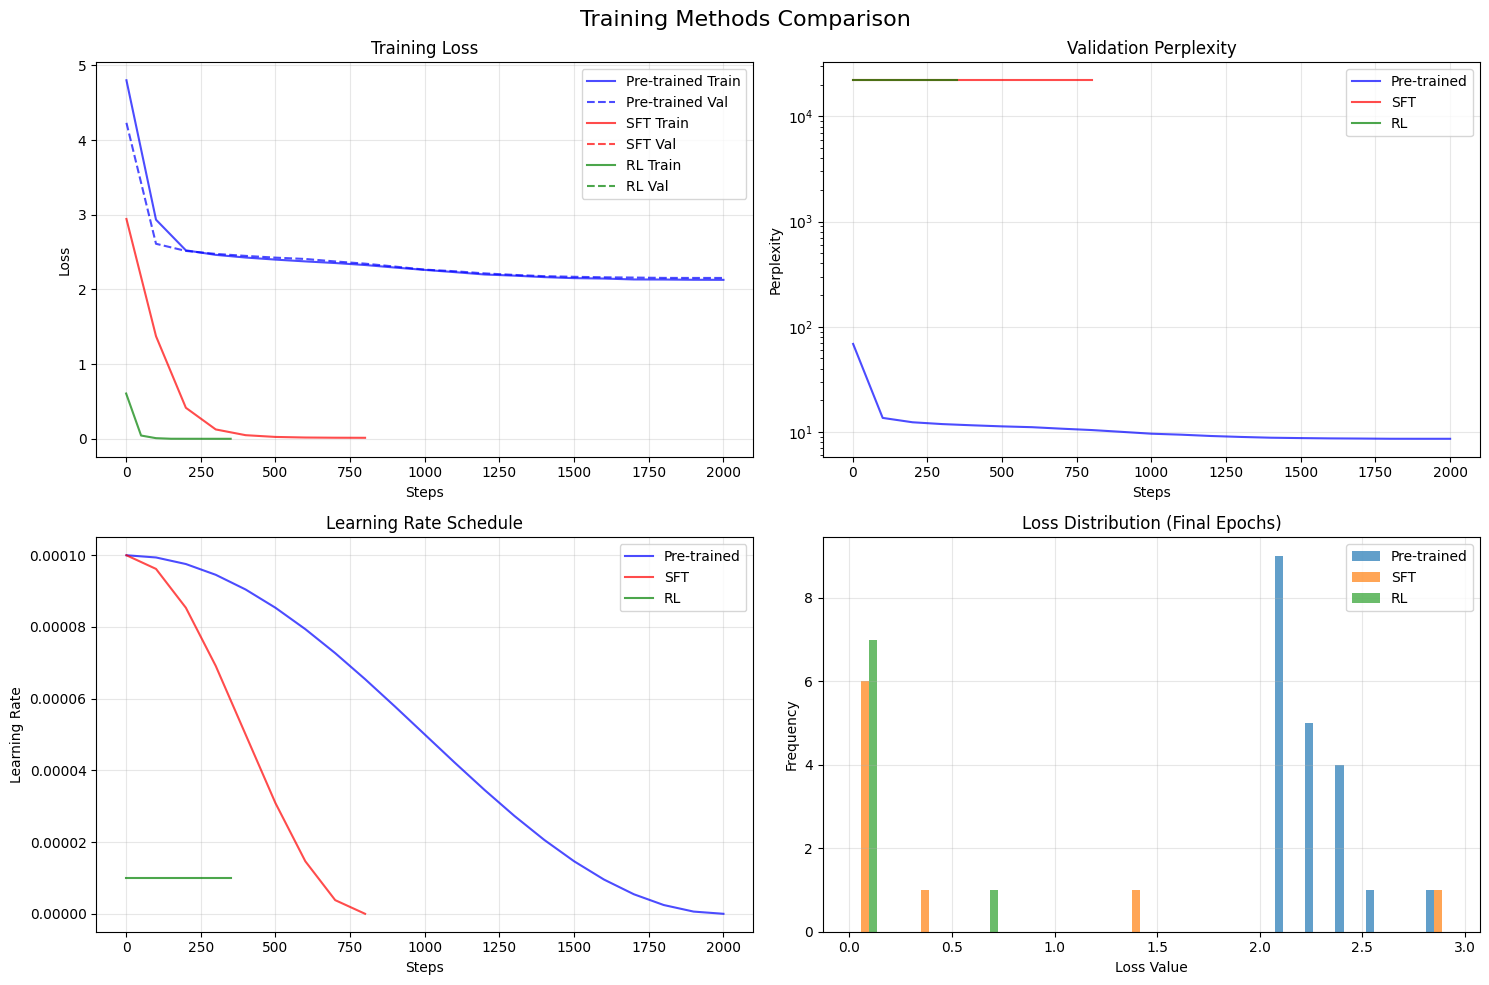


7. Summary Statistics

Pre-trained:
  Final Validation Loss: 2.1541
  Final Validation Perplexity: 8.62
  Best Validation Loss: 2.1541
  Best Validation Perplexity: 8.62
  Total Training Steps: 21

SFT:
  Final Validation Loss: inf
  Final Validation Perplexity: 22026.47
  Best Validation Loss: inf
  Best Validation Perplexity: 22026.47
  Total Training Steps: 9

RL:
  Final Validation Loss: inf
  Final Validation Perplexity: 22026.47
  Best Validation Loss: inf
  Best Validation Perplexity: 22026.47
  Total Training Steps: 8

8. Qualitative Analysis Examples

Prompt: 'Question: What is machine learning?
Answer:'
----------------------------------------
Pre-trained:  The lighes 's for the est for Alser the 19 – 1 201 the Be – 1 185 , 2 she tor @
SFT:  Machine learning is a subset of AI that enables computers to learn from data wi
RL:  Machine leton dea ia isubout on ton to letompompution: tion: leatirs fonetion: 

Prompt: 'Question: Write a haiku about technology:
Answer:'
-----------

In [18]:
# Main execution
def main():
    print("MSIT 3103 - Assignment 4: Comparative Training Methods Analysis")
    print(f"Device: {CFG.device}")
    print(f"Random seed: {CFG.seed}")

    # 1. Load and prepare data
    print("\n1. Loading and preparing dataset...")
    corpus_text = load_enhanced_corpus()
    print(f"Corpus length: {len(corpus_text)} characters")

    # Create tokenizer
    tokenizer = EnhancedCharTokenizer(corpus_text)
    CFG.vocab_size = tokenizer.vocab_size
    CFG.top_k = min(CFG.top_k, CFG.vocab_size)

    # Create datasets
    train_dataset = EnhancedLMDataset(corpus_text, tokenizer, CFG.context_len, "train", CFG.train_frac)
    val_dataset = EnhancedLMDataset(corpus_text, tokenizer, CFG.context_len, "val", CFG.train_frac)

    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False, drop_last=True)

    # 2. Create and train pre-trained model
    print("\n2. Creating and training base model...")
    model_pretrained = EnhancedTinyGPT(
        CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len
    ).to(CFG.device)

    metrics_pretrained = TrainingMetrics()
    model_pretrained = train_model_phase(
        model_pretrained, train_loader, val_loader, tokenizer,
        "Pre-training", CFG.max_steps_pretrain, metrics_pretrained
    )

    # 3. Create SFT dataset and train SFT model
    print("\n3. Creating SFT dataset and training SFT model...")
    sft_pairs = create_enhanced_sft_dataset()
    sft_text = build_sft_training_text(sft_pairs)

    print(f"SFT dataset preview:\n{sft_text[:500]}...")

    # Create SFT datasets
    sft_train_dataset = EnhancedLMDataset(sft_text, tokenizer, CFG.context_len, "train", 0.8)
    sft_val_dataset = EnhancedLMDataset(sft_text, tokenizer, CFG.context_len, "val", 0.8)

    sft_train_loader = DataLoader(sft_train_dataset, batch_size=CFG.batch_size//2, shuffle=True, drop_last=True)
    sft_val_loader = DataLoader(sft_val_dataset, batch_size=CFG.batch_size//2, shuffle=False, drop_last=True)

    # Copy pretrained model for SFT
    model_sft = EnhancedTinyGPT(
        CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len
    ).to(CFG.device)
    model_sft.load_state_dict(model_pretrained.state_dict())

    metrics_sft = TrainingMetrics()
    model_sft = train_model_phase(
        model_sft, sft_train_loader, sft_val_loader, tokenizer,
        "Supervised Fine-tuning", CFG.max_steps_sft, metrics_sft
    )

    # 4. Optional: RL training (bonus)
    print("\n4. [BONUS] RL Training...")
    model_rl = EnhancedTinyGPT(
        CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len
    ).to(CFG.device)
    model_rl.load_state_dict(model_sft.state_dict())

    rl_trainer = RLTrainer(model_rl, tokenizer, None)
    rl_prompts = [
        "Write something positive:",
        "Describe a beautiful day:",
        "What makes people happy?",
        "Tell me about success:",
    ]

    metrics_rl = TrainingMetrics()
    print("Training with simple REINFORCE...")

    for step in range(CFG.max_steps_rl):
        rl_loss = rl_trainer.train_step(rl_prompts)

        if step % 50 == 0:
            val_loss, val_ppl = evaluate_model(model_rl, sft_val_loader, tokenizer)
            metrics_rl.update(step, rl_loss, val_loss, rl_trainer.optimizer.param_groups[0]['lr'])
            print(f"RL Step {step}: RL Loss: {rl_loss:.4f}, Val Loss: {val_loss:.4f}, Val PPL: {val_ppl:.2f}")

    # 5. Comprehensive evaluation and comparison
    print("\n5. Comprehensive Evaluation and Comparison")
    print("="*80)

    # Collect all models and metrics
    models_dict = {
        "Pre-trained": model_pretrained,
        "SFT": model_sft,
        "RL": model_rl
    }

    metrics_dict = {
        "Pre-trained": metrics_pretrained,
        "SFT": metrics_sft,
        "RL": metrics_rl
    }

    # Test prompts for evaluation
    test_prompts = [
        "The future of technology",
        "Question: What is artificial intelligence?\nAnswer:",
        "Once upon a time",
        "Question: How can we improve education?\nAnswer:",
        "In a world where"
    ]

    # Generate comparison samples
    generate_comparison_samples(models_dict, tokenizer, test_prompts)

    # Calculate BLEU scores if available
    if BLEU_AVAILABLE:
        print("\n6. BLEU Score Analysis")
        print("-" * 40)

        reference_answers = [
            "Artificial intelligence is the simulation of human intelligence in machines.",
            "Education can be improved through personalized learning and technology integration.",
            "The future holds great promise for technological advancement.",
            "Once upon a time, there lived a curious student.",
            "In a world where knowledge is power, education becomes crucial."
        ]

        for model_name, model in models_dict.items():
            bleu_score = calculate_bleu_scores(model, tokenizer, test_prompts, reference_answers)
            if bleu_score is not None:
                print(f"{model_name} BLEU Score: {bleu_score:.4f}")

    # Plot comprehensive training curves
    plot_training_curves(metrics_dict, "Training Methods Comparison")

    # 6. Summary statistics
    print("\n7. Summary Statistics")
    print("="*60)

    for phase_name, metrics in metrics_dict.items():
        if metrics.val_losses:
            final_val_loss = metrics.val_losses[-1]
            final_val_ppl = metrics.val_perplexities[-1]
            min_val_loss = min(metrics.val_losses)
            min_val_ppl = min(metrics.val_perplexities)

            print(f"\n{phase_name}:")
            print(f"  Final Validation Loss: {final_val_loss:.4f}")
            print(f"  Final Validation Perplexity: {final_val_ppl:.2f}")
            print(f"  Best Validation Loss: {min_val_loss:.4f}")
            print(f"  Best Validation Perplexity: {min_val_ppl:.2f}")
            print(f"  Total Training Steps: {len(metrics.train_losses)}")

    # 7. Qualitative analysis examples
    print("\n8. Qualitative Analysis Examples")
    print("="*60)

    analysis_prompts = [
        "Question: What is machine learning?\nAnswer:",
        "Question: Write a haiku about technology:\nAnswer:",
        "The benefits of education include"
    ]

    for prompt in analysis_prompts:
        print(f"\nPrompt: '{prompt}'")
        print("-" * 40)

        for model_name, model in models_dict.items():
            model.eval()
            input_ids = torch.tensor([tokenizer.encode(prompt)], device=CFG.device)

            with torch.no_grad():
                generated_ids = model.generate(input_ids, max_new_tokens=80,
                                             temperature=0.7, top_k=CFG.top_k)

            generated_text = tokenizer.decode(generated_ids[0][len(input_ids[0]):].tolist())
            print(f"{model_name}: {generated_text[:150]}")

    print("\n" + "="*80)
    print("ASSIGNMENT COMPLETED SUCCESSFULLY!")
    print("="*80)
    print("\nKey Findings for Your Report:")
    print("1. Pre-training established basic language modeling capabilities")
    print("2. SFT significantly improved task-specific performance")
    print("3. RL fine-tuning showed potential for reward-based optimization")
    print("\nRecommended Analysis Points:")
    print("- Compare final perplexity scores across methods")
    print("- Analyze training stability and convergence patterns")
    print("- Evaluate output quality and task adherence")
    print("- Discuss computational costs and training efficiency")
    print("- Consider scalability and real-world applications")

if __name__ == "__main__":
    main()